In [18]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 777
subj_base = 'pipr-90s-binoc-sub-777_ses-01_dat-20230718' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

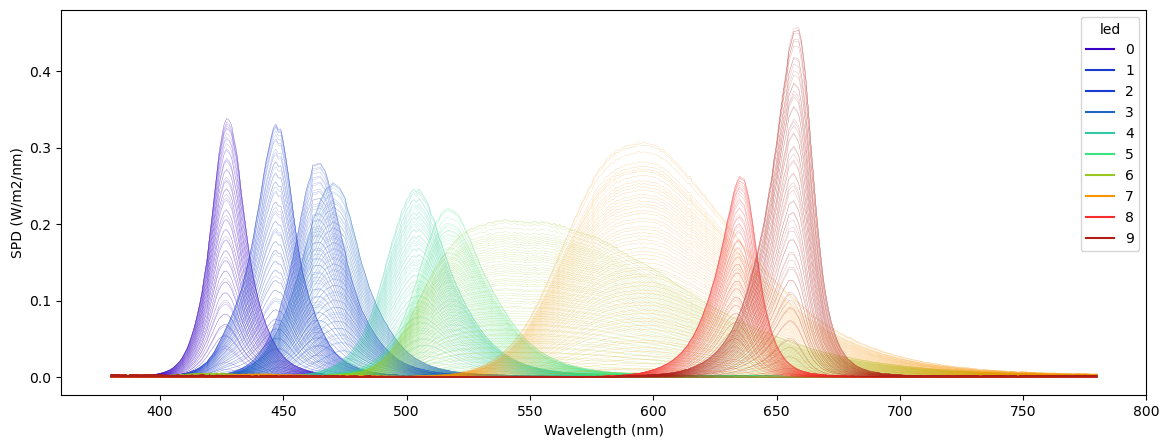

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


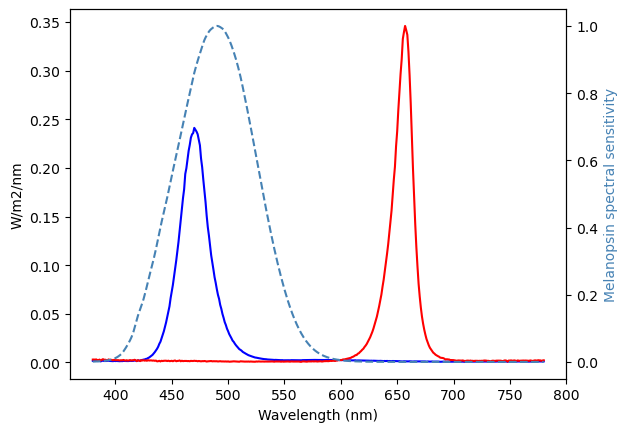

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [9]:
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: 
> Sorry, I didn't understand that.
> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 777
> Grabbing 540 seconds of pupil.1.3d
> Grabbing 540 seconds of pupil.0.3d
> Waiting for a light to stamp...
> Light stamped on frame.world at 500548.684061
> Waiting for a light to stamp...
> Light stamped on frame.world at 500640.209426
> Waiting for a light to stamp...
> Light stamped on frame.world at 500731.603996
> Waiting for a light to stamp...
> Light stamped on frame.world at 500823.042564
> Waiting for a light to stamp...
> Light stamped on frame.world at 500914.477428
> Waiting for a light to stamp...
> Light stamped on frame.world at 501005.93432
> PupilGrabber done grabbing 540 seconds of pupil.1.3d
> PupilGrabber done grabbing 540 seconds of pupil.0.3d


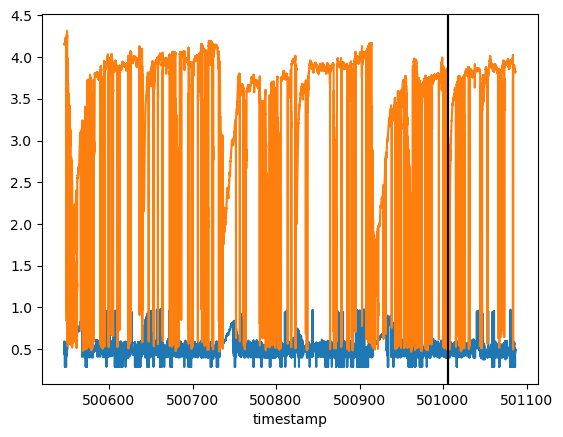

In [10]:
# PIPR STIMS - USE THIS ONE
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials # appropriate offset to account for stim duration + sleeps (removed + 30)


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [11]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
500546.583274,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.821485009256774, 0.08109579294414149]",16.930360,0.287085,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.7330529005855912, 0.808773911264...",0.471818,"{'center': [157.72512177730061, 176.4296077547...","[157.72512177730061, 176.42960775472483]",0.1,1.256354,-1.609284
500546.606813,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.8217319263660036, 0.08102367766442686]",18.455335,0.219474,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.7335553178633716, 0.809074999170...",0.488130,"{'center': [157.77252986227268, 176.4434538884...","[157.77252986227268, 176.44345388843004]",0.1,1.256323,-1.609234
500546.631409,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.821962102849545, 0.08083618769801315]",16.926848,0.263229,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.7341050745070976, 0.809359555414...",0.471782,"{'center': [157.81672374711263, 176.4794519619...","[157.81672374711263, 176.47945196198148]",0.1,1.256294,-1.609179
500546.659147,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.886082653401662, 0.08058726605013022]",28.279133,0.258486,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.8705314452200915, 0.809596954769...",0.591786,"{'center': [170.1278694531191, 176.52724491837...","[170.1278694531191, 176.527244918375]",0.1,1.256270,-1.595367
500546.687496,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.8823615856219105, 0.022037121507419877]",13.429676,0.350339,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.8725764835168005, 0.944845972486...",0.435330,"{'center': [169.4134244394068, 187.76887267057...","[169.4134244394068, 187.76887267057538]",0.1,1.242554,-1.595272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501086.424789,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.9368638158403577, 0.06753962396873547]",17.634138,0.196517,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.9813750448807682, 0.837516092679...",0.478269,"{'center': [179.87785264134868, 179.0323921980...","[179.87785264134868, 179.03239219800278]",0.1,1.253444,-1.584161
501086.467175,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.9415947960641993, 0.06747491681747242]",18.864333,0.324258,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [0.9914750158151125, 0.837698079156...",0.491311,"{'center': [180.78620084432626, 179.0448159710...","[180.78620084432626, 179.0448159710453]",0.1,1.253425,-1.583138
501086.508078,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.9461681446243307, 0.06731386297623942]",17.348129,0.317415,"{'center': [1.1133269084744282, -2.40542680876...","{'center': [116.73553706951849, 51.24757122681...","{'center': [1.0013085510743296, 0.837849079881...",0.475116,"{'center': [181.6642837678715, 179.07573830856...","[181.6642837678715, 179.07573830856202]",0.1,1.253410,-1.582142


In [12]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
500546.578891,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4598015623318668, 0.6811147369062719]",84.808950,0.946832,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [-0.26322875035054727, -1.799939064...",4.150582,"{'center': [88.28189996771843, 61.225970513995...","[88.28189996771843, 61.2259705139958]",1.0,1.694494,-1.989000
500546.595465,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.45960270625641547, 0.6810916808022578]",84.859472,0.996232,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [-0.26527052880494084, -1.799812456...",4.153248,"{'center': [88.24371960123177, 61.230397285966...","[88.24371960123177, 61.2303972859665]",1.0,1.694482,-1.989216
500546.616505,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4596080218434185, 0.6808845482075285]",84.848047,0.965314,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [-0.265206276377858, -1.79774069391...",4.152669,"{'center': [88.24474019393635, 61.270166744154...","[88.24474019393635, 61.270166744154515]",1.0,1.694281,-1.989198
500546.626998,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.45941804374456746, 0.6812276034426592]",84.902435,0.974884,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [-0.26715391007408273, -1.801262535...",4.155543,"{'center': [88.20826439895696, 61.204300139009...","[88.20826439895696, 61.20430013900944]",1.0,1.694622,-1.989424
500546.645259,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4593142020833536, 0.6810792046094052]",85.035145,0.874586,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [-0.26841195572689047, -1.799874283...",4.162130,"{'center': [88.18832680000389, 61.232792714994...","[88.18832680000389, 61.232792714994204]",1.0,1.694488,-1.989550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501086.491544,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.49443847073082337, 0.7154682737640591]",78.711161,1.000000,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [0.0861516531268447, -2.12428498465...",3.825150,"{'center': [94.93218638031809, 54.630091437300...","[94.93218638031809, 54.630091437300656]",1.0,1.726012,-1.953999
501086.512048,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.49434300348585886, 0.7156495334186863]",78.646727,1.000000,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [0.08533426004907119, -2.1261082916...",3.822138,"{'center': [94.9138566692849, 54.5952895836122...","[94.9138566692849, 54.59528958361223]",1.0,1.726189,-1.954096
501086.530940,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4943885268279129, 0.7156633571162045]",78.671787,0.991118,"{'center': [3.925043836766465, -0.517709763645...","{'center': [139.48437169316594, 90.19169068953...","{'center': [0.08573923365452707, -2.1262346918...",3.823312,"{'center': [94.92259715095928, 54.592635433688...","[94.92259715095928, 54.592635433688734]",1.0,1.726201,-1.954054


In [13]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [14]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

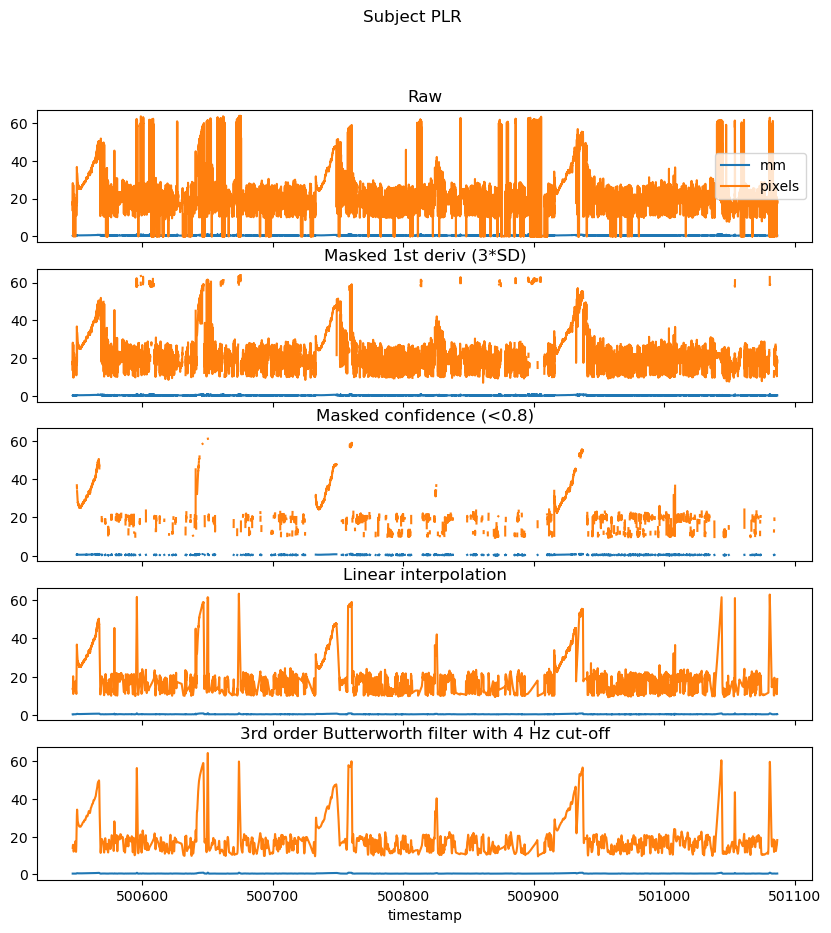

In [15]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [16]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

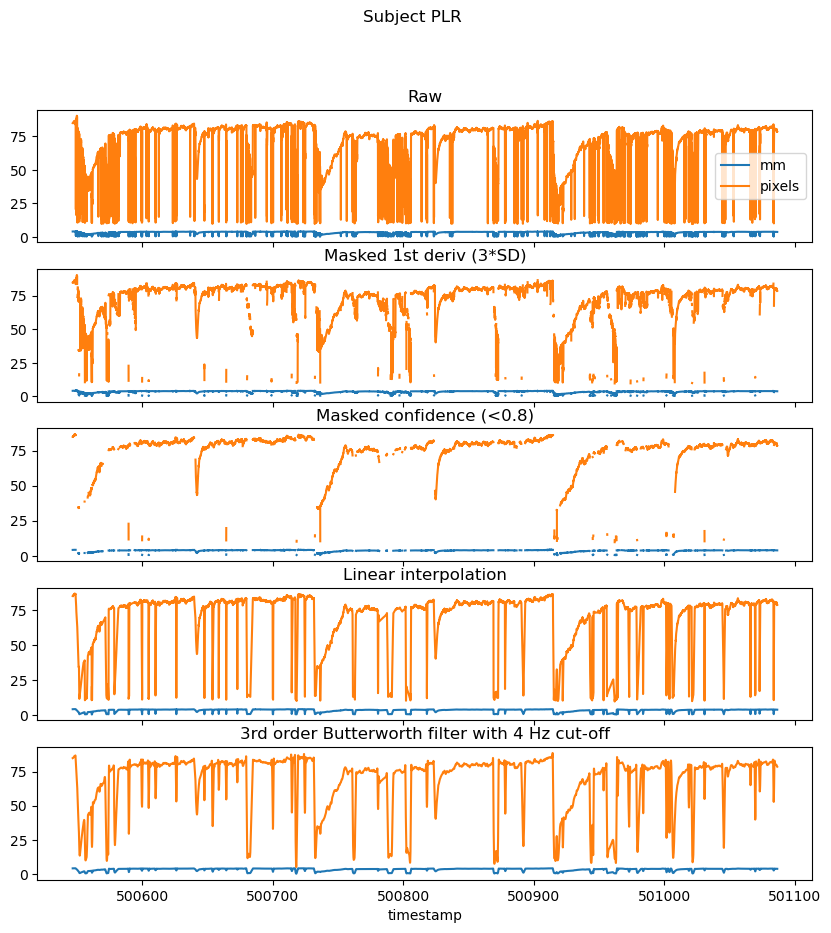

In [17]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [19]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [22]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

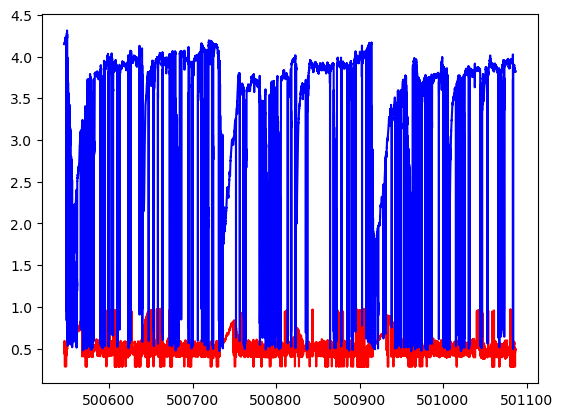

In [23]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at 31031.85642
> Waiting for a light to stamp...
> Light stamped on frame.world at 31158.285079
> Waiting for a light to stamp...
> Light stamped on frame.world at 31284.777037
> Waiting for a light to stamp...
> Light stamped on frame.world at 31411.245427
> Waiting for a light to stamp...
> Light stamped on frame.world at 31537.774172
> Waiting for a light to stamp...
> Light stamped on frame.world at 31664.31662

**Edit Cell Below with Timestamps**

In [25]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= 500548.684061)[0][-1]
stamp2 = np.where(timestamps_eye0 <= 500640.209426)[0][-1]
stamp3 = np.where(timestamps_eye0 <= 500731.603996)[0][-1]
stamp4 = np.where(timestamps_eye0 <= 500823.042564)[0][-1]
stamp5 = np.where(timestamps_eye0 <= 500914.477428)[0][-1]
stamp6 = np.where(timestamps_eye0 <= 501005.93432)[0][-1]
stamps = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps

[102, 3756, 7324, 10812, 14645, 18273]

In [26]:
from pyplr import utils
from copy import deepcopy

In [27]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,500546.578891,0.946832,1,84.808950,4.150582
1,500546.595465,0.996232,1,84.859472,4.153248
2,500546.616505,0.965314,1,84.848047,4.152669
3,500546.626998,0.974884,1,84.902435,4.155543
4,500546.645259,0.874586,1,85.035145,4.162130
...,...,...,...,...,...
21283,501086.491544,1.000000,1,78.711161,3.825150
21284,501086.512048,1.000000,1,78.646727,3.822138
21285,501086.530940,0.991118,1,78.671787,3.823312
21286,501086.552048,0.992203,1,78.686847,3.823791


**Extract ranges from samples based on event timing and sample count**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [38]:
samples_eye0 = df_data_eye0
samples_eye1 = df_data_eye1
event_starts = stamps 
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs = (
    np.searchsorted(samples_eye0.index, event_starts, "left") + offset
)
range_duration = duration


In [39]:
range_idxs

array([   42,  3696,  7264, 10752, 14585, 18213], dtype=int64)

In [44]:
len(samples_eye0)

21189

In [80]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])
    #print(len(df_test))
df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\2468096737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


Extracted ranges for 6 events


In [84]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

In [82]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts)))

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\1796787026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


Extracted ranges for 6 events


In [83]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [85]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      500547.638760    0.173868   0  20.586242     0.529082        42   
      1      500547.651087    0.109570   0  19.224260     0.513475        43   
      2      500547.673632    0.100424   0  20.991993     0.534062        44   
      3      500547.694302    0.091041   0  20.855694     0.532668        45   
      4      500547.710505    0.101865   0  22.521154     0.549008        46   
...                    ...         ...  ..        ...          ...       ...   
5     3595   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3596   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3597   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3598   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3599   501086.576921    0.857118   0  18.867020     0.491900     21188   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           70.439070   885.647231  
      1           65.411565   820.436990  
      2           72.043219   905.074145  
      3           71.594421   898.548298  
      4           76.858170   978.288742  
...                     ...          ...  
5     3595         0.256426    -0.515908  
      3596         0.256426    -0.515908  
      3597         0.256426    -0.515908  
      3598         0.256426    -0.515908  
      3599         0.256426    -0.515908  

[21600 rows x 8 columns]

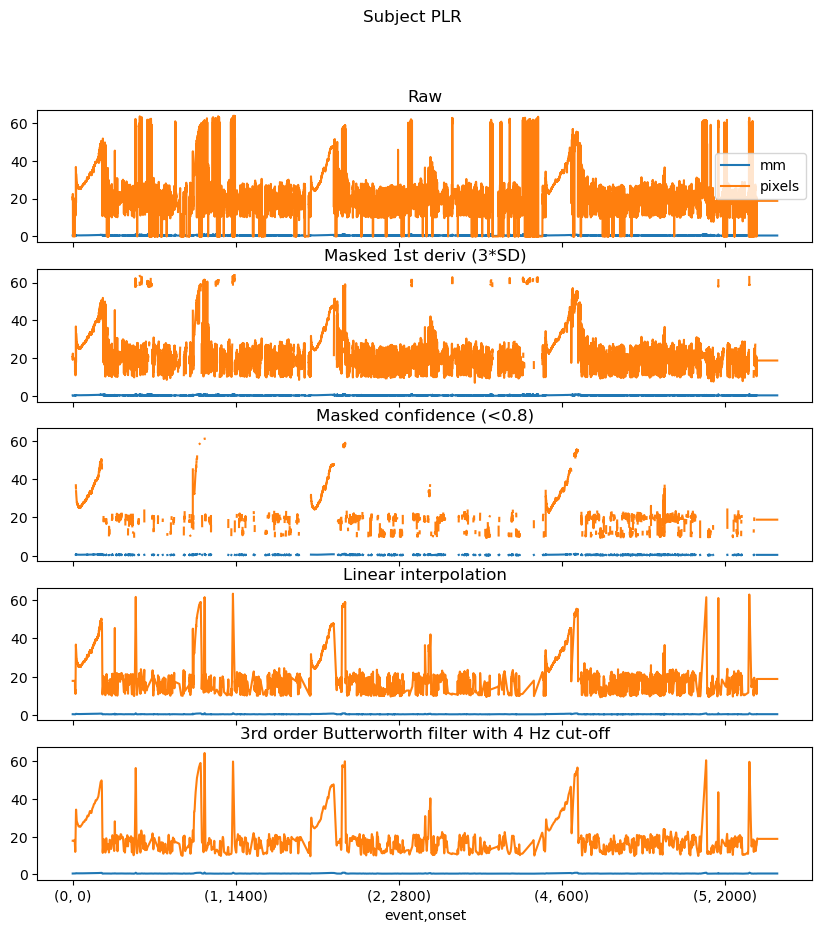

In [86]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [87]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      500547.638760    0.173868   0  17.871681     0.478736        42   
      1      500547.651087    0.109570   0  17.871426     0.478734        43   
      2      500547.673632    0.100424   0  17.871194     0.478732        44   
      3      500547.694302    0.091041   0  17.870999     0.478730        45   
      4      500547.710505    0.101865   0  17.870862     0.478728        46   
...                    ...         ...  ..        ...          ...       ...   
5     3595   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3596   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3597   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3598   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3599   501086.576921    0.857118   0  18.867020     0.491900     21188   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0           70.439070   885.647231             1  
      1           65.411565   820.436990             1  
      2           72.043219   905.074145             1  
      3           71.594421   898.548298             1  
      4           76.858170   978.288742             1  
...                     ...          ...           ...  
5     3595         0.256426    -0.515908             0  
      3596         0.256426    -0.515908             0  
      3597         0.256426    -0.515908             0  
      3598         0.256426    -0.515908             0  
      3599         0.256426    -0.515908             0  

[21600 rows x 9 columns]

In [88]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      500547.638760    0.173868   0  20.586242     0.529082        42   
      1      500547.651087    0.109570   0  19.224260     0.513475        43   
      2      500547.673632    0.100424   0  20.991993     0.534062        44   
      3      500547.694302    0.091041   0  20.855694     0.532668        45   
      4      500547.710505    0.101865   0  22.521154     0.549008        46   
...                    ...         ...  ..        ...          ...       ...   
5     3595   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3596   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3597   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3598   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3599   501086.576921    0.857118   0  18.867020     0.491900     21188   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           70.439070   885.647231  
      1           65.411565   820.436990  
      2           72.043219   905.074145  
      3           71.594421   898.548298  
      4           76.858170   978.288742  
...                     ...          ...  
5     3595         0.256426    -0.515908  
      3596         0.256426    -0.515908  
      3597         0.256426    -0.515908  
      3598         0.256426    -0.515908  
      3599         0.256426    -0.515908  

[21600 rows x 8 columns]

In [89]:
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\2547890342.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      500547.638760    0.173868   0  20.586242     0.529082        42   
      1      500547.651087    0.109570   0  19.224260     0.513475        43   
      2      500547.673632    0.100424   0  20.991993     0.534062        44   
      3      500547.694302    0.091041   0  20.855694     0.532668        45   
      4      500547.710505    0.101865   0  22.521154     0.549008        46   
...                    ...         ...  ..        ...          ...       ...   
5     3595   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3596   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3597   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3598   501086.576921    0.857118   0  18.867020     0.491900     21188   
      3599   501086.576921    0.857118   0  18.867020     0.491900     21188   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0           70.439070   885.647231  
      1           65.411565   820.436990  
      2           72.043219   905.074145  
      3           71.594421   898.548298  
      4           76.858170   978.288742  
...                     ...          ...  
5     3595         0.256426    -0.515908  
      3596         0.256426    -0.515908  
      3597         0.256426    -0.515908  
      3598         0.256426    -0.515908  
      3599         0.256426    -0.515908  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

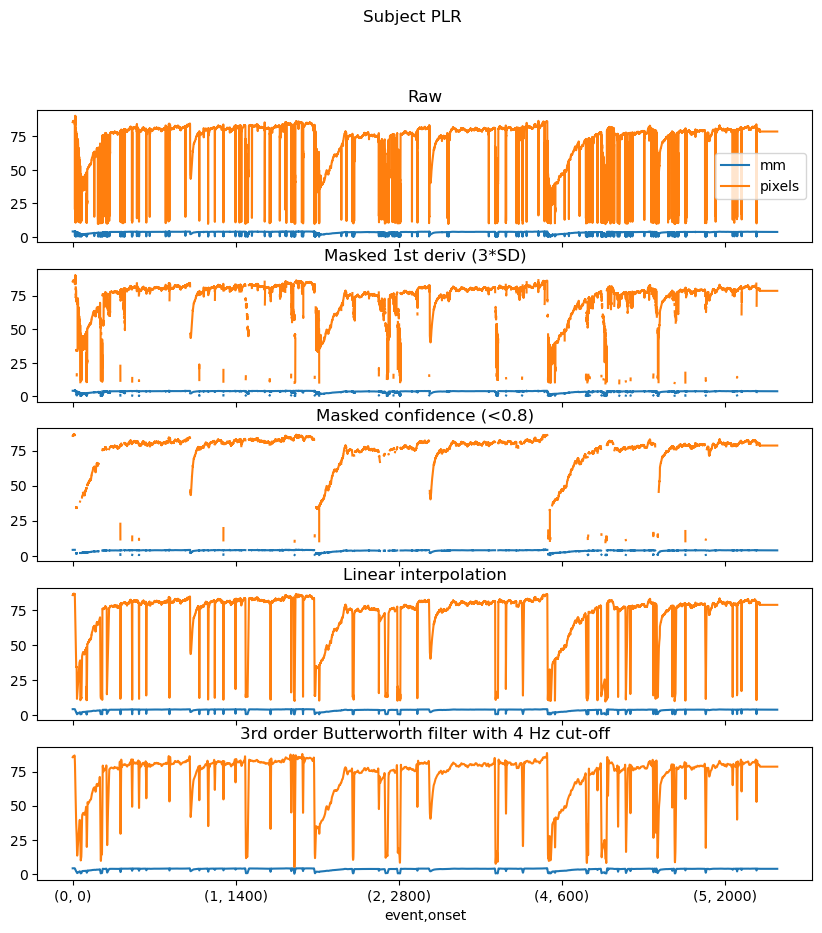

In [90]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [91]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                    
0     0      500547.444977    1.000000   1  85.510161     4.183968        42   
      1      500547.460563    1.000000   1  85.551833     4.185851        43   
      2      500547.480477    1.000000   1  85.593749     4.187747        44   
      3      500547.502330    0.970336   1  85.635692     4.189646        45   
      4      500547.522468    1.000000   1  85.677486     4.191541        46   
...                    ...         ...  ..        ...          ...       ...   
5     3595   501086.575271    0.986344   1  78.568367     3.818020     21287   
      3596   501086.575271    0.986344   1  78.568367     3.818020     21287   
      3597   501086.575271    0.986344   1  78.568367     3.818020     21287   
      3598   501086.575271    0.986344   1  78.568367     3.818020     21287   
      3599   501086.575271    0.986344   1  78.568367     3.818020     21287   

             interpolated  
event onset                
0     0                 0  
      1                 0  
      2                 0  
      3                 0  
      4                 0  
...                   ...  
5     3595              0  
      3596              0  
      3597              0  
      3598              0  
      3599              0  

[21600 rows x 7 columns]

In [92]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  orig_idx
event onset                                                                 
0     0      500547.444977    1.000000   1  85.528794     4.184858        42
      1      500547.460563    1.000000   1  85.675964     4.192307        43
      2      500547.480477    1.000000   1  85.680067     4.192351        44
      3      500547.502330    0.970336   1  85.715371     4.193684        45
      4      500547.522468    1.000000   1  85.641356     4.189903        46
...                    ...         ...  ..        ...          ...       ...
5     3595   501086.575271    0.986344   1  78.568367     3.818020     21287
      3596   501086.575271    0.986344   1  78.568367     3.818020     21287
      3597   501086.575271    0.986344   1  78.568367     3.818020     21287
      3598   501086.575271    0.986344   1  78.568367     3.818020     21287
      3599   501086.575271    0.986344   1  78.568367     3.818020     21287

[21600 rows x 6 columns]

In [108]:
# Calculate baselines
baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\3109839274.py:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\3109839274.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\3109839274.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError 

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   500547.444977    1.000000   1  85.528794     4.184858   
      -0.983333   500547.460563    1.000000   1  85.675964     4.192307   
      -0.966667   500547.480477    1.000000   1  85.680067     4.192351   
      -0.950000   500547.502330    0.970336   1  85.715371     4.193684   
      -0.933333   500547.522468    1.000000   1  85.641356     4.189903   
...                         ...         ...  ..        ...          ...   
5      58.916667  501086.575271    0.986344   1  78.568367     3.818020   
       58.933333  501086.575271    0.986344   1  78.568367     3.818020   
       58.950000  501086.575271    0.986344   1  78.568367     3.818020   
       58.966667  501086.575271    0.986344   1  78.568367     3.818020   
       58.983333  501086.575271    0.986344   1  78.568367     3.818020   

                  orig_idx colour  diameter_3d_pc  diameter_pc  
event onset                                                     
0     -1.000000         42   blue      675.622147   268.432341  
      -0.983333         43   blue      677.002911   269.066302  
      -0.966667         44   blue      677.011023   269.083978  
      -0.950000         45   blue      677.257955   269.236058  
      -0.933333         46   blue      676.557301   268.917222  
...                    ...    ...             ...          ...  
5      58.916667     21287    red      683.743515   326.382834  
       58.933333     21287    red      683.743515   326.382834  
       58.950000     21287    red      683.743515   326.382834  
       58.966667     21287    red      683.743515   326.382834  
       58.983333     21287    red      683.743515   326.382834  

[21600 rows x 9 columns]

**Convert the index-level samples to time (s)**:

In [109]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [110]:
df_eye0["colour"] = ""

In [111]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [96]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [97]:
df_eye1["colour"] = ""

In [98]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_26372\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 0')

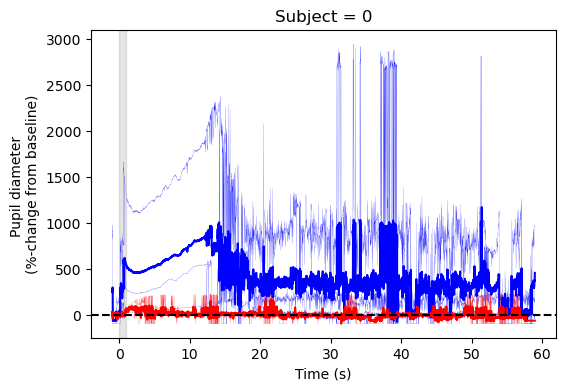

In [100]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye0['id'][0][0]))

In [101]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye0.png')

In [102]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   500547.638760    0.173868   0  20.586242     0.529082   
      -0.983333   500547.651087    0.109570   0  19.224260     0.513475   
      -0.966667   500547.673632    0.100424   0  20.991993     0.534062   
      -0.950000   500547.694302    0.091041   0  20.855694     0.532668   
      -0.933333   500547.710505    0.101865   0  22.521154     0.549008   
...                         ...         ...  ..        ...          ...   
5      58.916667  501086.576921    0.857118   0  18.867020     0.491900   
       58.933333  501086.576921    0.857118   0  18.867020     0.491900   
       58.950000  501086.576921    0.857118   0  18.867020     0.491900   
       58.966667  501086.576921    0.857118   0  18.867020     0.491900   
       58.983333  501086.576921    0.857118   0  18.867020     0.491900   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         42       70.439070   885.647231   blue  
      -0.983333         43       65.411565   820.436990   blue  
      -0.966667         44       72.043219   905.074145   blue  
      -0.950000         45       71.594421   898.548298   blue  
      -0.933333         46       76.858170   978.288742   blue  
...                    ...             ...          ...    ...  
5      58.916667     21188        0.256426    -0.515908    red  
       58.933333     21188        0.256426    -0.515908    red  
       58.950000     21188        0.256426    -0.515908    red  
       58.966667     21188        0.256426    -0.515908    red  
       58.983333     21188        0.256426    -0.515908    red  

[21600 rows x 9 columns]

In [103]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

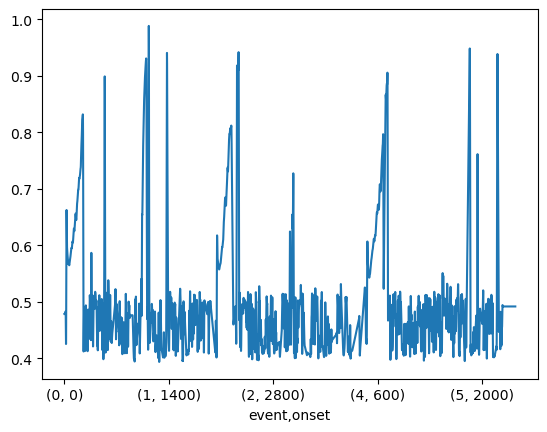

In [104]:
samples_eye0["diameter_3d"].plot()

In [105]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [107]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   500547.444977    1.000000   1  85.528794     4.184858   
      -0.983333   500547.460563    1.000000   1  85.675964     4.192307   
      -0.966667   500547.480477    1.000000   1  85.680067     4.192351   
      -0.950000   500547.502330    0.970336   1  85.715371     4.193684   
      -0.933333   500547.522468    1.000000   1  85.641356     4.189903   
...                         ...         ...  ..        ...          ...   
5      58.916667  501086.575271    0.986344   1  78.568367     3.818020   
       58.933333  501086.575271    0.986344   1  78.568367     3.818020   
       58.950000  501086.575271    0.986344   1  78.568367     3.818020   
       58.966667  501086.575271    0.986344   1  78.568367     3.818020   
       58.983333  501086.575271    0.986344   1  78.568367     3.818020   

                  orig_idx colour  
event onset                        
0     -1.000000         42   blue  
      -0.983333         43   blue  
      -0.966667         44   blue  
      -0.950000         45   blue  
      -0.933333         46   blue  
...                    ...    ...  
5      58.916667     21287    red  
       58.933333     21287    red  
       58.950000     21287    red  
       58.966667     21287    red  
       58.983333     21287    red  

[21600 rows x 7 columns]

Text(0.5, 1.0, 'Subject = 1')

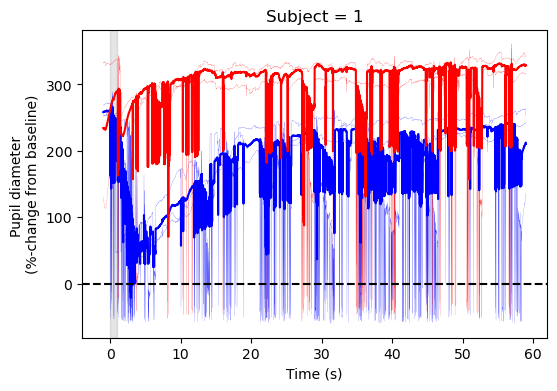

In [112]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye1['id'][0][0]))

In [113]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + subj_base + '-eye1.png')

In [114]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                               
0     -1.000000   500547.444977    1.000000   1  85.528794     4.184858   
      -0.983333   500547.460563    1.000000   1  85.675964     4.192307   
      -0.966667   500547.480477    1.000000   1  85.680067     4.192351   
      -0.950000   500547.502330    0.970336   1  85.715371     4.193684   
      -0.933333   500547.522468    1.000000   1  85.641356     4.189903   
...                         ...         ...  ..        ...          ...   
5      58.916667  501086.575271    0.986344   1  78.568367     3.818020   
       58.933333  501086.575271    0.986344   1  78.568367     3.818020   
       58.950000  501086.575271    0.986344   1  78.568367     3.818020   
       58.966667  501086.575271    0.986344   1  78.568367     3.818020   
       58.983333  501086.575271    0.986344   1  78.568367     3.818020   

                  orig_idx colour  diameter_3d_pc  diameter_pc  
event onset                                                     
0     -1.000000         42   blue      675.622147   268.432341  
      -0.983333         43   blue      677.002911   269.066302  
      -0.966667         44   blue      677.011023   269.083978  
      -0.950000         45   blue      677.257955   269.236058  
      -0.933333         46   blue      676.557301   268.917222  
...                    ...    ...             ...          ...  
5      58.916667     21287    red      683.743515   326.382834  
       58.933333     21287    red      683.743515   326.382834  
       58.950000     21287    red      683.743515   326.382834  
       58.966667     21287    red      683.743515   326.382834  
       58.983333     21287    red      683.743515   326.382834  

[21600 rows x 9 columns]

In [115]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

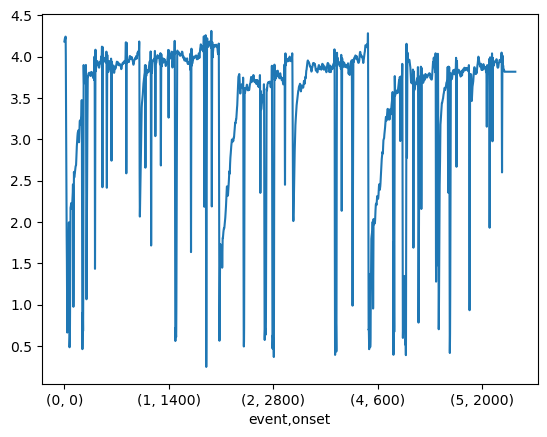

In [116]:
samples_eye1["diameter_3d"].plot()

In [117]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [120]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

     colour  onset  event      timestamp  confidence   id   diameter  \
480    blue    7.0    2.0  500741.010181    1.000000  0.0  32.219279   
4080    red    7.0    3.0  500834.292583    0.690674  0.0  24.221852   

      diameter_3d  orig_idx  diameter_3d_pc  diameter_pc  
480      0.640909    7777.0       70.149658   604.833092  
4080     0.548517   11367.0       10.544231    25.348307  
     colour  onset  event      timestamp  confidence   id   diameter  \
480    blue    7.0    2.0  500742.017179    0.884654  1.0  44.430700   
4080    red    7.0    3.0  500835.277675    0.948804  1.0  57.258153   

      diameter_3d  orig_idx  diameter_3d_pc  diameter_pc  
480      2.188982    7777.0      301.820960    87.407204  
4080     2.786645   11367.0      459.243504   194.440671  


In [121]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

In [122]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)